# Aufgabe-F-FilmDialoge

## Allgemeines

Eine allgemeine Beschreibung der Laboraufgaben inklusive des Vorgehens, den Bewertungsrichtlinien und der Abgabe finden Sie  <a href="ML-allgemein.ipynb">hier</a>

## Datenquelle


* Laden Sie ihre Daten von http://141.72.190.207/ml_lab/F_dialoge herunter
    * Die Daten sind geschützt. 
        * Sie müssen evtl. in einem Netzwerk der DHBW (z.B. WLAN, VPN, ...) angemeldet sein. 
        * Sie können sich auf der Webseite mit dem Benutzernamen dhbw und dem Zugangsnamen "ml_LaB_4$" anmelden. 
* Die Daten sind in einem anwendungsspezifischen Format gespeichert.
    * Sie finden evtl. Informationen über die Daten in einer "README" Datei. 
    * Finden Sie keine solche Datei sind die Daten selbst erklärend. 
    
    



## Aufgabe

Die Daten-Sammlung 
* besteht aus Dialogen aus verschiedensten Filmen
* ist in der Readme Datei beschrieben

Erstellen Sie aus den einen Chatbot, der auf eine Frage mit einer Antwort im "Filmjargon" antwortet! 
* Verwenden Sie tiefe Neuronale Netze zu Erstellen des Chatbots! 
* Passen Sie den Chatbot so an, dass er für unterschiedliche Film-Genres unterschiedlich antwortet! 


# Lösung

Die Lösung der Aufgabe besteht aus mehreren Teilschritten, welche im Folgenden kurz genannt werden:

* Daten einlesen
* Daten vorverarbeiten
* Model erstellen
* Model trainieren
* Model abspeichern
* Model ausführen


# Abhängigkeiten des Projekts

* Tensorflow 2.8.2

In [57]:
import tensorflow as tf
import random
import re
import numpy


# Eigene Abhängigkeiten des Projekts

* 

In [58]:
import sys
import importlib
from pathlib import Path
module_path = str(Path.cwd() / "src")
if module_path not in sys.path:
    sys.path.append(module_path)

import data_helper as dh

importlib.reload(dh)

<module 'data_helper' from 'c:\\Users\\noah\\source\\repos\\ML-Projekt\\src\\data_helper.py'>

## Konstanten

In [59]:
max_train_size = 25000
max_test_size = 10000

# Daten einlesen

Hier werden zuerst die rohen Daten eingelesen und innerhalb der Hilfsfunktion "readDataToLines" mit des "newline" Zeichen getrennt. Die Daten werden zwei Listen gespeichert, welche dann zurückgegeben werden.
Verwendet wurden folgende Funktionen:

* "open" um die Datei zu öffnen
* "read" um die Datei zu lesen
* "split" um die Daten anhand des "newline" Zeichen zu trennen und in einer Liste zu speichern

In [60]:
# read the data from the files
movie_lines, movie_conversations = dh.readDataToLines("data/unzipped/movie_lines.txt", "data/unzipped/movie_conversations.txt")

# Daten vorverarbeiten

In [61]:
conversations_list = dh.readConversationsToList(movie_conversations)

# create a dictionary that maps each line id to the corresponding line
id2line = dh.readLinesToDict(movie_lines)

# remove all unnecessary characters from the lines and replace short forms with the full words
id2line = dh.cleanLines(id2line)

# split the conversations into requests and responses, each answer is used as a request for the next answer
request, response = dh.splitConversationsToRequestAndResponse(conversations_list, id2line)

# delete temporary variables
del(movie_lines, movie_conversations, conversations_list, id2line)

### Parameter wählen

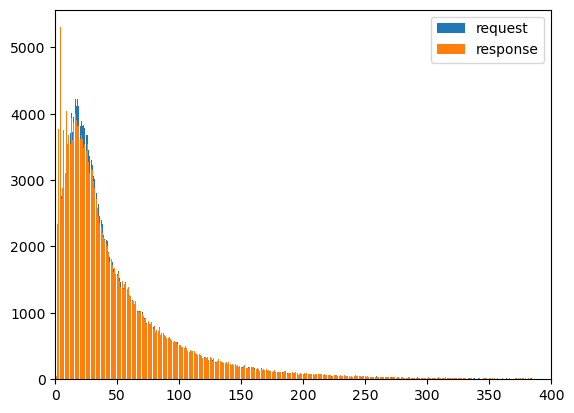

In [62]:
# convert the data into a list of conversations
from matplotlib import pyplot as plt

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# get the length of each line of the requests and save the occurrences in a dictionary
lengths_request = {}
for sentence in request:
    length = len(sentence)
    if length in lengths_request:
        lengths_request[length] += 1
    else:
        lengths_request[length] = 1

# get the length of each line of the responses and save the occurrences in a dictionary
lengths_response = {}
for sentence in response:
    length = len(sentence)
    if length in lengths_response:
        lengths_response[length] += 1
    else:
        lengths_response[length] = 1

# plot the occurrences of the lengths of the requests and responses in the same plot while only showind x values up to 200
plt.bar(lengths_request.keys(), lengths_request.values(), label="request")
plt.bar(lengths_response.keys(), lengths_response.values(), label="response")
plt.xlim(0, 400)
plt.legend()
plt.show()


# based on the result set the parameters
max_wordcount_in_sentence = 200


Wie man in der obigen Grafik erkennt, sind ab einer Sequenzlänge von 200 nur noch wenige Daten vorhanden. Da die Sequenzlänge maßgeblich auch für den Speicherbedarf in weiteren Schritten ist, wird diese hier auf 200 begrenzt.

In [63]:
# remove every request and its corresponding response if one of them has more words than max_wordcount_in_sentence
request, response = dh.removeLongSequences(request, response, max_wordcount_in_sentence)

# limit the size of the dataset
test_request = request[max_train_size:max_train_size+max_test_size]
test_response = response[max_train_size:max_train_size+max_test_size]

request = request[0:max_train_size]
response = response[0:max_train_size]


# get a dictionary of all unique words with their frequency
word2count = dh.getWord2Count(request, response)

# filter out words with a frequency of 5 or less
min_wordFrequency = 5
word2count = {k:v for k,v in word2count.items() if v > min_wordFrequency}

del(min_wordFrequency)

# create a dictionary that maps each word to a unique integer, used in the encoder
# tokens: <S> (Start), <E> (End), <N> (Null), <F> (Filler)
# add the tokens to the front of the dictionary to optimize searching while shifting the indices of the other words by 4
word2index = {}
word2index["<F>"] = 0
word2index["<S>"] = 1
word2index["<E>"] = 2
word2index["<N>"] = 3
word2index |= {k:v+4 for v,k in enumerate(word2count.keys())} #merge dictionaries
# this line of code creates a dictionary word2index by using a dictionary comprehension
# the comprehension iterates over the keys of the dictionary word2count and assigns each key a value that is the index of the key plus 4 (the first 4 indices are reserved for the tokens)
# v takes the values 0, 1, 2, ... and k takes the values of the keys of the word2count dictionary
# the enumerate function generates a sequence of index, value pairs from the keys of the word2count dictionary
# the dictionary comprehension creates a new dictionary with the keys from word2count as the keys of word2index and the values of word2index being the index of the keys in word2count plus 4.

# invert the dictionary word2index to create a dictionary that maps each integer to a unique word, used in the decoder
index2word = {k:v for v,k in word2index.items()}

# save the dictionaries to the disk to use them later
dh.saveDictionary(word2index, "data/word2index.dict")
dh.saveDictionary(index2word, "data/index2word.dict")

# encapsule the responses with the tokens <S> (Start) and <E> (End)
response = dh.encapsuleWithTokens(response, "<S>", "<E>")



del(word2count)

# translate the inputs to numeric values and uses the null token <N> when the word is not in the dictionary
inputEncoder = dh.translateToNumeric(request, word2index, "<N>") 
inputDecoder = dh.translateToNumeric(response, word2index, "<N>") 
test_inputEncoder = dh.translateToNumeric(test_request, word2index, "<N>")
test_inputDecoder = dh.translateToNumeric(test_response, word2index, "<N>")

# remove start token from decoder input so that the decoder doesn't learn to just copy the start token to each output, don't remove the end token because the decoder should learn when to stop with generating output
outputDecoder = dh.removeStartToken(inputDecoder)
test_outputDecoder = dh.removeStartToken(test_inputDecoder)

del(request, response)

In [64]:
# get the maximum length of the requests
max_length_request = max([len(x) for x in inputEncoder])
# get the maximum length of the responses
max_length_response = max([len(x) for x in inputDecoder])
# get the maximum length of the test requests
max_length_test_request = max([len(x) for x in test_inputEncoder])
# get the maximum length of the test responses
max_length_test_response = max([len(x) for x in test_inputDecoder])
# get the maximum length of the requests, responses and test requests and responses
max_length = max(max_length_request, max_length_response, max_length_test_request, max_length_test_response)

In [65]:
# use the keras function pad_sequences to pad the data with zeros (which represent a filling token) to the maximum length
inputEncoder = tf.keras.preprocessing.sequence.pad_sequences(inputEncoder, maxlen=max_length, padding="post", truncating="post")
inputDecoder = tf.keras.preprocessing.sequence.pad_sequences(inputDecoder, maxlen=max_length, padding="post", truncating="post")
outputDecoder = tf.keras.preprocessing.sequence.pad_sequences(outputDecoder, maxlen=max_length, padding="post", truncating="post")
test_inputEncoder = tf.keras.preprocessing.sequence.pad_sequences(test_inputEncoder, maxlen=max_length, padding="post", truncating="post")
test_inputDecoder = tf.keras.preprocessing.sequence.pad_sequences(test_inputDecoder, maxlen=max_length, padding="post", truncating="post")
test_outputDecoder = tf.keras.preprocessing.sequence.pad_sequences(test_outputDecoder, maxlen=max_length, padding="post", truncating="post")

# convert the decoder input to a one-hot encoded vector which the model can use
outputDecoder = tf.keras.utils.to_categorical(outputDecoder, num_classes=len(word2index), dtype="float32") # using float32 even though it's memory intensive because later steps need it to be float32
test_outputDecoder = tf.keras.utils.to_categorical(test_outputDecoder, num_classes=len(word2index), dtype="float32")


# Model erstellen

Das Erzeugen der einzelnen Layer ist in der Reihenfolge implementiert, nach welcher Daten das Model durchlaufen.


In [66]:
#hyperparameters
outputDimension = 50 
lstm_units = 256

#encoder input, embedding and lstm

# input tensor for the encoder, shape of each vector is determined by max_length which was also used to pad the data
inputEncoderTensor = tf.keras.Input(shape=(max_length, ), name = "inputEncoderTensor")

# embedding layer of the encoder, the input is the input tensor, the output is the embedding tensor
encoderEmbedding = tf.keras.layers.Embedding(len(word2index) + 1, output_dim = outputDimension, input_length = max_length, trainable = True, name = "embeddingEncoderLayer")(inputEncoderTensor)

# LSTM layer of the encoder, the input is the embedding tensor, the output is the output tensor and the hidden state of the encoder
encoderLSTM, encoderHiddenState, encoderCellState = tf.keras.layers.LSTM(units = lstm_units, return_sequences = True, return_state = True, name = "lstmEncoderLayer")(encoderEmbedding)



#decoder input, embedding, lstm and dense

# input tensor for the decoder, shape of each vector is determined by max_length which was also used to pad the data
inputDecoderTensor = tf.keras.Input(shape=(max_length, ), name="inputDecoderTensor")

# embedding layer of the decoder, the input is the input tensor, the output is the embedding tensor
decoderEmbedding = tf.keras.layers.Embedding(len(word2index) + 1, output_dim = outputDimension, input_length = max_length, trainable = True, name = "embeddingDecoderLayer")(inputDecoderTensor)

# LSTM layer of the decoder, the input is the embedding tensor and the state of the previous lstm layer, the output is the output tensor and the hidden state of the decoder
decoderLSTM, decoderHiddenState, decoderCellState = tf.keras.layers.LSTM(units = lstm_units, return_sequences = True, return_state = True, name = "lstmDecoderLayer")(decoderEmbedding, initial_state = [encoderHiddenState, encoderCellState])

# dense layer of the decoder, the input is the output tensor of the lstm layer, the output is the output tensor of the dense layer
# the dense layer has the same number of units as the number of words in the dictionary because the output of the dense layer is a vector with a probability for each word in the dictionary
decoderDense = tf.keras.layers.Dense(units = len(word2index), activation = "softmax", name = "denseLayer")(decoderLSTM)

# Define the model 
model = tf.keras.models.Model([inputEncoderTensor, inputDecoderTensor], decoderDense)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy')

# generate an early stopping callback to stop training when the validation loss stops improving so that the model doesn't overfit
# waits 3 epochs before stopping
# use val_loss as the metric because categorical_crossentropy calculates the difference between the predicted and actual values and by monitoring wether or not the loss would be decreasing or increasing we can see if the model is improving or not
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

# Train the model on the training data and evaluate it on the validation data
model.fit(x=[inputEncoder, inputDecoder],y=outputDecoder , epochs=10, batch_size=32, callbacks=[earlyStopping])

# Evaluate the model on the validation set and store the results
loss, accuracy = model.evaluate([test_inputEncoder, test_inputDecoder], test_outputDecoder)
print('Test loss:', loss)
print('Test accuracy:', accuracy)


Epoch 1/10
782/782 [==============================] - 609s 773ms/step - loss: 1.2838
Epoch 2/10
782/782 [==============================] - 599s 767ms/step - loss: 1.0478
Epoch 3/10
782/782 [==============================] - 618s 790ms/step - loss: 0.9849
Epoch 4/10
782/782 [==============================] - 599s 766ms/step - loss: 0.9514
Epoch 5/10
782/782 [==============================] - 593s 759ms/step - loss: 0.9290
Epoch 6/10
782/782 [==============================] - 583s 746ms/step - loss: 0.9108
Epoch 7/10
782/782 [==============================] - 595s 760ms/step - loss: 0.8952
Epoch 8/10
782/782 [==============================] - 582s 745ms/step - loss: 0.8810
Epoch 9/10
782/782 [==============================] - 608s 778ms/step - loss: 0.8678
Epoch 10/10
500/782 [==================>...........] - ETA: 4:02 - loss: 0.8520

# Model trainieren

# Model abspeichern

In [ ]:
for layer in model.layers:
    weights = layer.get_weights()
    if weights != []:
        numpy.savez(f'models/{layer.name}.npz', weights)

# Model ausführen